# Case Study 2: Revenue Management


## Q1 – Calibrate Advance Sale Policies

Clara offers discounted advance rates — but only up to a certain number of bookings. Selling too many rooms in advance may lead to turning away spontaneous, higher-paying guests. Selling too few could leave occupancy short.

Using realized stays identify meaningful guest segments for each hotel. When do different types of guests book? What prices do they pay?

Estimate how many rooms Clara could allocate to advance sales for each property. Focus on lead times and potentially guest mix.


In [299]:
# imports
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

In [300]:
hotel_bookings = pd.read_csv("hotel_bookings.csv")

hotel_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [301]:
hotel_bookings.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [302]:
# split up in two datasets for each hotel and filter out cancellations
city_hotel = hotel_bookings[
    (hotel_bookings["hotel"] == "City Hotel") & (hotel_bookings["is_canceled"] == 0)
]

resort_hotel = hotel_bookings[
    (hotel_bookings["hotel"] == "Resort Hotel") & (hotel_bookings["is_canceled"] == 0)
]

### Splitting up in segments


In [303]:
# business travelers (filter by company id)
def get_business_travelers(df):
    return df[df["market_segment"] == "Corporate"]


# family with at least one kid/baby
def get_families(df):
    return df[((df["children"] > 0) | (df["babies"] > 0)) & (df["adults"] >= 2)]


# recurring guests
def get_loyal_guests(df):
    return df[(df["is_repeated_guest"] == 1)]


# group guests (bigger groups from e.g. events)
def get_group_guests(df):
    return df[df["customer_type"] == "Group"]


# early bookers (by lead time threshhold)
def get_early_bookers(df, threshhold=60):
    return df[df["lead_time"] > threshhold]


# late bookers (by lead time threshhold)
def get_late_bookers(df, threshhold=60):
    return df[df["lead_time"] <= threshhold]

### Split up customer types in different segments


In [304]:
def create_lead_time_plot(hotel):

    business = get_business_travelers(hotel)
    families = get_families(hotel)
    loyal = get_loyal_guests(hotel)
    groups = get_group_guests(hotel)

    figure, axes = plt.subplots(2, 2, figsize=(12, 8))
    # Plot lead time distributions for each segment
    # Define bins and labels for lead time groups
    bins = [0, 7, 30, 90, 180, float("inf")]
    labels = ["<=7", "8-30", "31-90", "91-180", ">180"]

    # Group lead times for each segment
    business_bins = pd.cut(business["lead_time"], bins=bins, labels=labels, right=True)
    families_bins = pd.cut(families["lead_time"], bins=bins, labels=labels, right=True)
    loyal_bins = pd.cut(loyal["lead_time"], bins=bins, labels=labels, right=True)
    groups_bins = pd.cut(groups["lead_time"], bins=bins, labels=labels, right=True)

    # Plot bar charts for each segment
    axes[0, 0].bar(
        business_bins.value_counts(sort=False).index,
        business_bins.value_counts(sort=False).values,
        color="tab:blue",
        alpha=0.7,
    )
    axes[0, 1].bar(
        families_bins.value_counts(sort=False).index,
        families_bins.value_counts(sort=False).values,
        color="tab:orange",
        alpha=0.7,
    )
    axes[1, 0].bar(
        loyal_bins.value_counts(sort=False).index,
        loyal_bins.value_counts(sort=False).values,
        color="tab:green",
        alpha=0.7,
    )
    axes[1, 1].bar(
        groups_bins.value_counts(sort=False).index,
        groups_bins.value_counts(sort=False).values,
        color="tab:red",
        alpha=0.7,
    )
    axes[0, 0].set_title("Business Travelers")
    axes[0, 0].set_xlabel("Lead Time (days)")
    axes[0, 0].set_ylabel("Count")

    axes[0, 1].set_title("Families")
    axes[0, 1].set_xlabel("Lead Time (days)")
    axes[0, 1].set_ylabel("Count")

    axes[1, 0].set_title("Loyal Guests")
    axes[1, 0].set_xlabel("Lead Time (days)")
    axes[1, 0].set_ylabel("Count")

    axes[1, 1].set_title("Group Guests")
    axes[1, 1].set_xlabel("Lead Time (days)")
    axes[1, 1].set_ylabel("Count")

    plt.tight_layout()

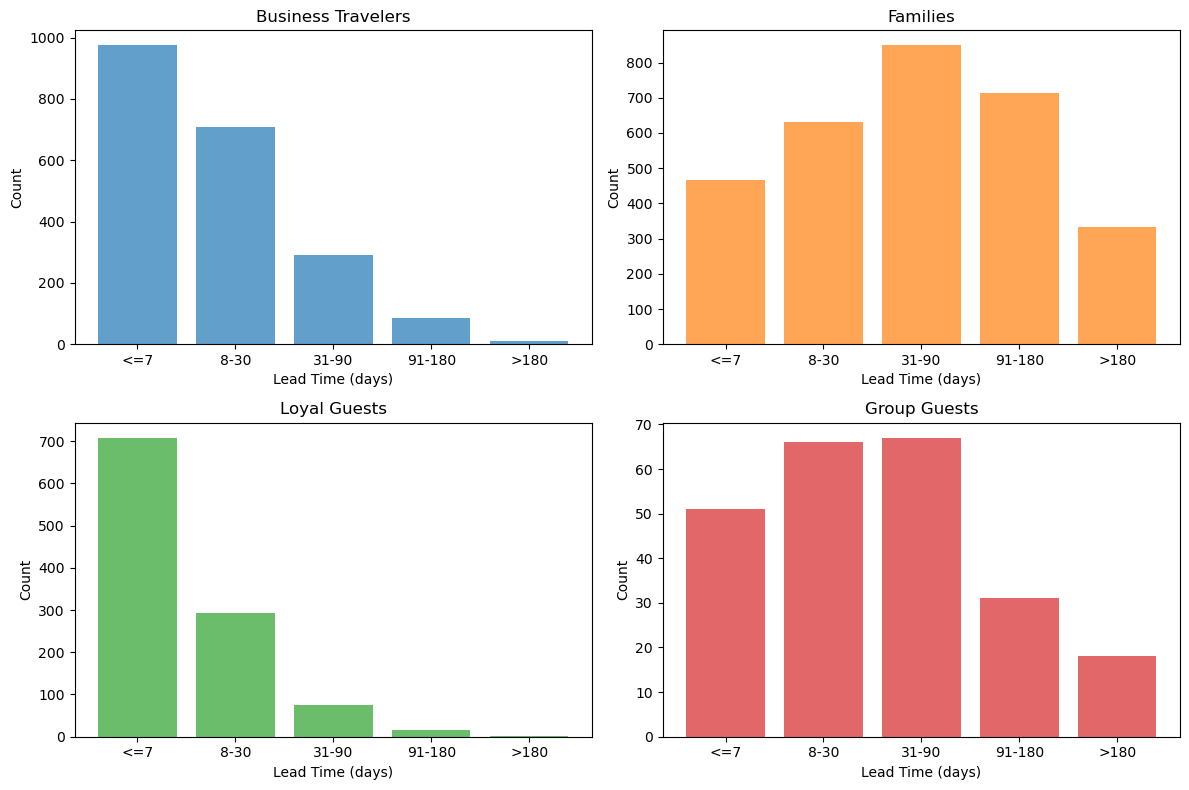

In [305]:
create_lead_time_plot(city_hotel)

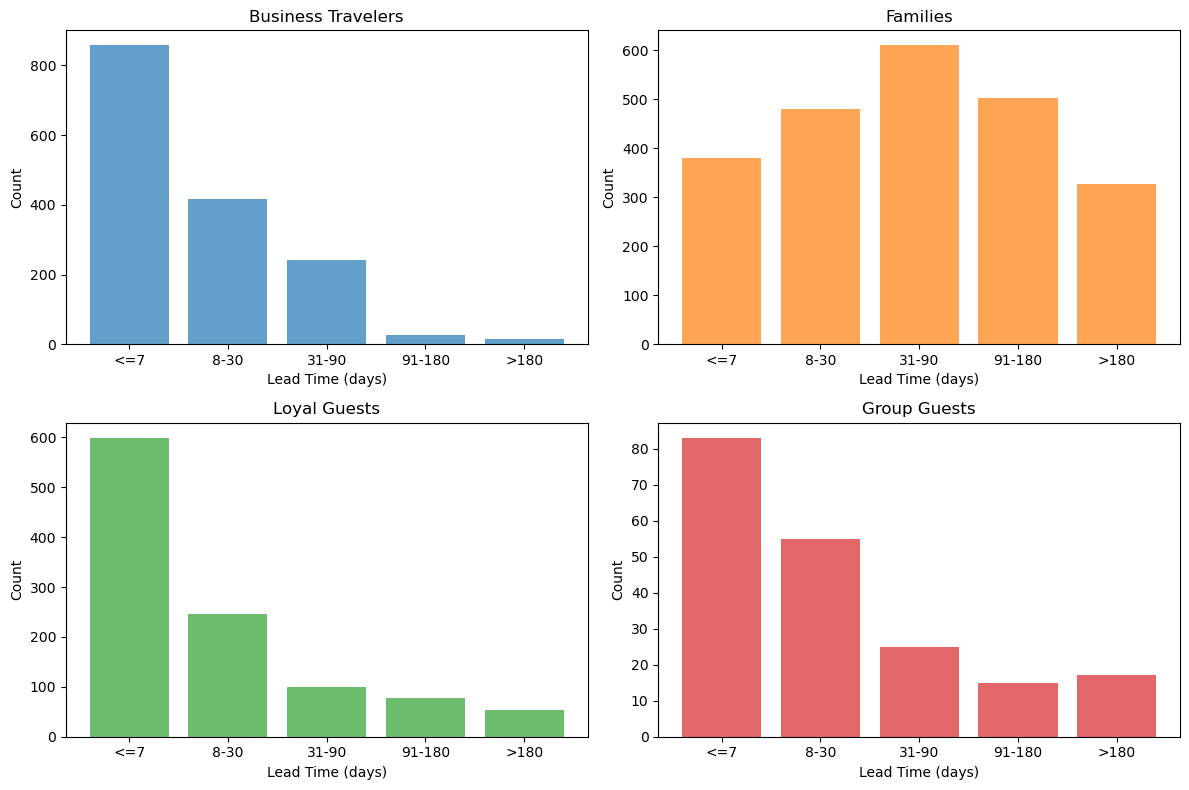

In [306]:
create_lead_time_plot(resort_hotel)

In [307]:
def create_adr_plot(hotel, title=""):
    figure, axes = plt.subplots(2, 2, figsize=(12, 8))
    figure.suptitle(title, fontsize=16)

    business = get_business_travelers(hotel)
    families = get_families(hotel)
    loyal = get_loyal_guests(hotel)
    groups = get_group_guests(hotel)

    axes[0, 0].hist(business["adr"].dropna(), bins=30, color="tab:blue", alpha=0.7)
    axes[0, 1].hist(families["adr"].dropna(), bins=30, color="tab:orange", alpha=0.7)
    axes[1, 0].hist(loyal["adr"].dropna(), bins=30, color="tab:green", alpha=0.7)
    axes[1, 1].hist(groups["adr"].dropna(), bins=30, color="tab:red", alpha=0.7)

    axes[0, 0].set_title("Business Travelers")
    axes[0, 0].set_xlabel("ADR (Price per Night)")
    axes[0, 0].set_ylabel("Count")

    axes[0, 1].set_title("Families")
    axes[0, 1].set_xlabel("ADR (Price per Night)")
    axes[0, 1].set_ylabel("Count")

    axes[1, 0].set_title("Loyal Guests")
    axes[1, 0].set_xlabel("ADR (Price per Night)")

    # Plot mean as a vertical line for each segment
    axes[0, 0].axvline(
        business["adr"].mean(),
        color="black",
        linestyle="dashed",
        linewidth=1,
        label=f'Mean ({business["adr"].mean():.2f})',
    )
    axes[0, 1].axvline(
        families["adr"].mean(),
        color="black",
        linestyle="dashed",
        linewidth=1,
        label=f'Mean ({families["adr"].mean():.2f})',
    )
    axes[1, 0].axvline(
        loyal["adr"].mean(),
        color="black",
        linestyle="dashed",
        linewidth=1,
        label=f'Mean ({loyal["adr"].mean():.2f})',
    )
    axes[1, 1].axvline(
        groups["adr"].mean(),
        color="black",
        linestyle="dashed",
        linewidth=1,
        label=f'Mean ({groups["adr"].mean():.2f})',
    )
    for ax in axes.flat:
        ax.legend()
    axes[1, 0].set_ylabel("Count")

    axes[1, 1].set_title("Group Guests")
    axes[1, 1].set_xlabel("ADR (Price per Night)")
    axes[1, 1].set_ylabel("Count")

    plt.tight_layout()

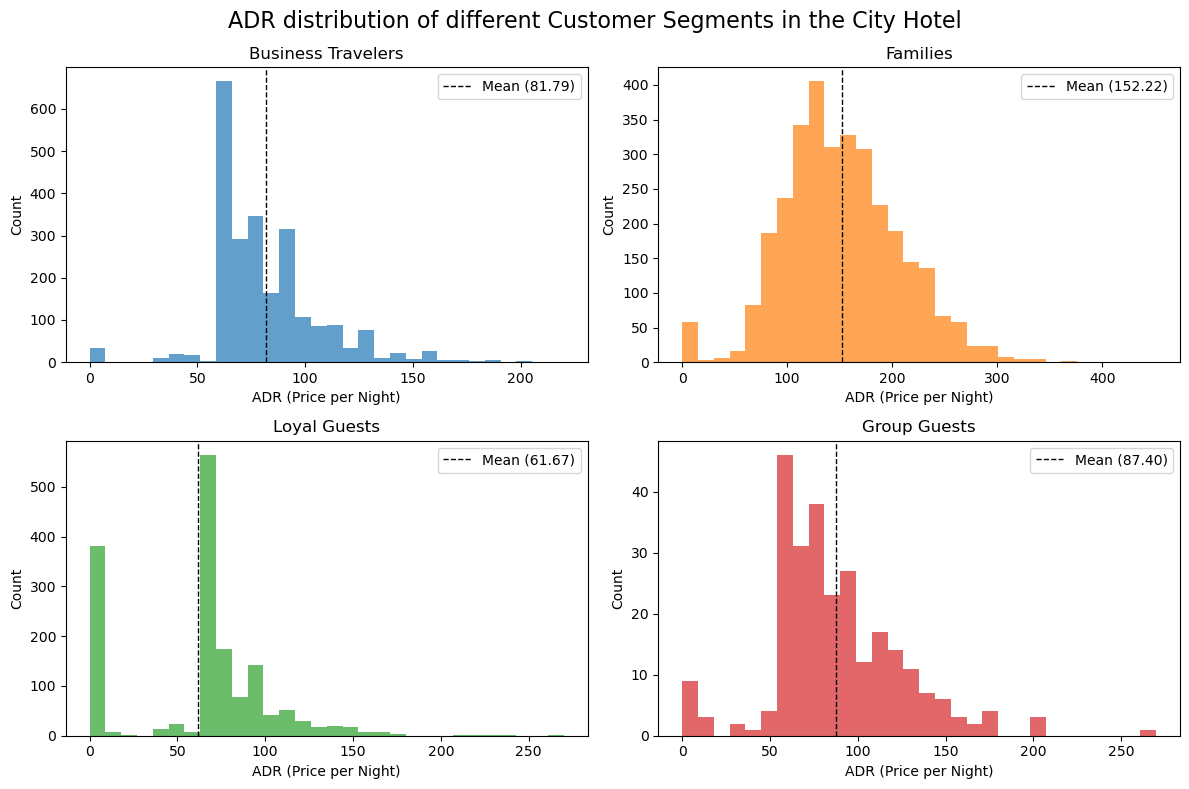

In [308]:
create_adr_plot(
    city_hotel, "ADR distribution of different Customer Segments in the City Hotel"
)

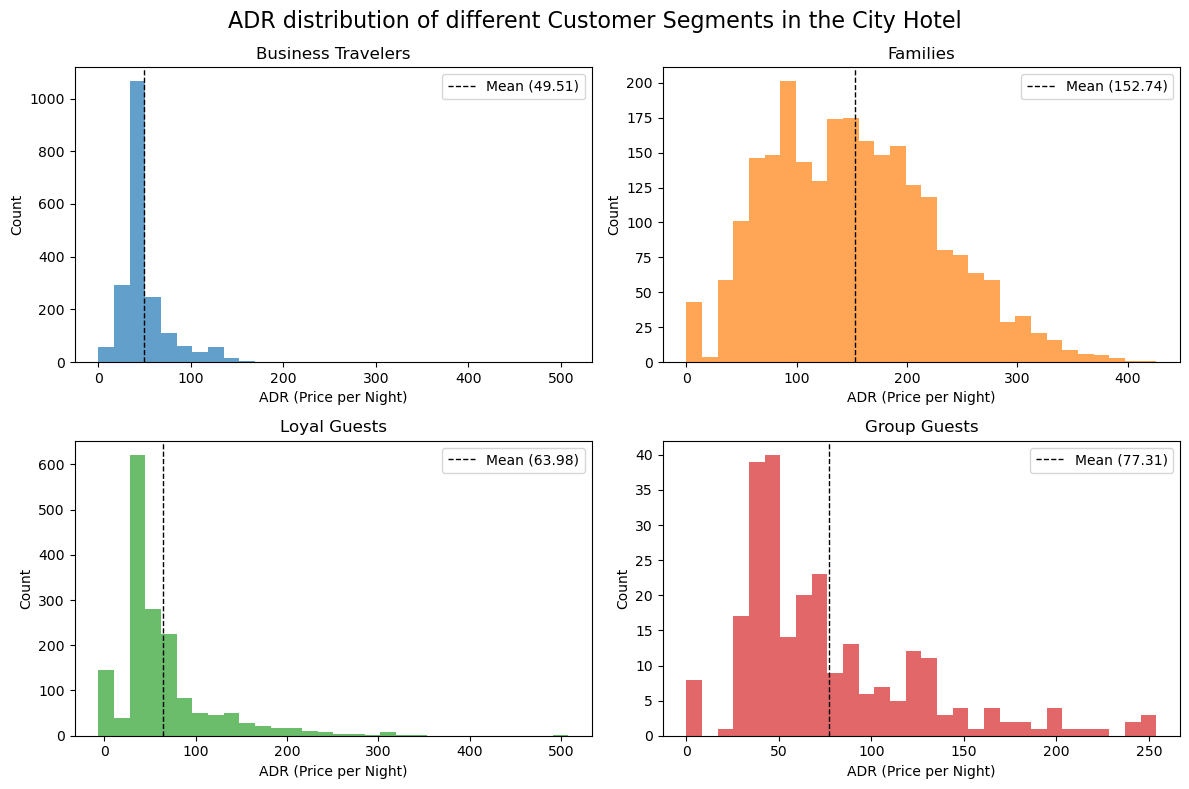

In [309]:
create_adr_plot(
    resort_hotel, "ADR distribution of different Customer Segments in the City Hotel"
)

In [310]:
def create_adr_plot_by_lead_time_threshhold(hotel, title="", threshhold=60):

    figure, axes = plt.subplots(2, figsize=(12, 8))
    figure.suptitle(title, fontsize=16)

    early = get_early_bookers(hotel, threshhold)
    late = get_late_bookers(hotel, threshhold)

    axes[0].hist(early["adr"].dropna(), bins=30, color="tab:blue", alpha=0.7)
    axes[1].hist(late["adr"].dropna(), bins=30, color="tab:orange", alpha=0.7)

    axes[0].set_title(f"Early Bookers (lead time over {threshhold} days)")
    axes[0].set_xlabel("ADR (Price per Night)")
    axes[0].set_ylabel("Count")

    axes[1].set_title(f"Late Bookers (lead time under {threshhold} days)")
    axes[1].set_xlabel("ADR (Price per Night)")
    axes[1].set_ylabel("Count")

    # Plot mean as a vertical line for each segment
    axes[0].axvline(
        early["adr"].mean(),
        color="black",
        linestyle="dashed",
        linewidth=1,
        label=f'Mean ({early["adr"].mean():.2f})',
    )
    axes[1].axvline(
        late["adr"].mean(),
        color="black",
        linestyle="dashed",
        linewidth=1,
        label=f'Mean ({late["adr"].mean():.2f})',
    )

    for ax in axes:
        ax.legend()

    plt.tight_layout()


def get_mean_adr_by_lead_time_threshhold(hotel, threshhold=60):
    early = get_early_bookers(hotel, threshhold)
    late = get_late_bookers(hotel, threshhold)

    return early["adr"].mean(), late["adr"].mean()

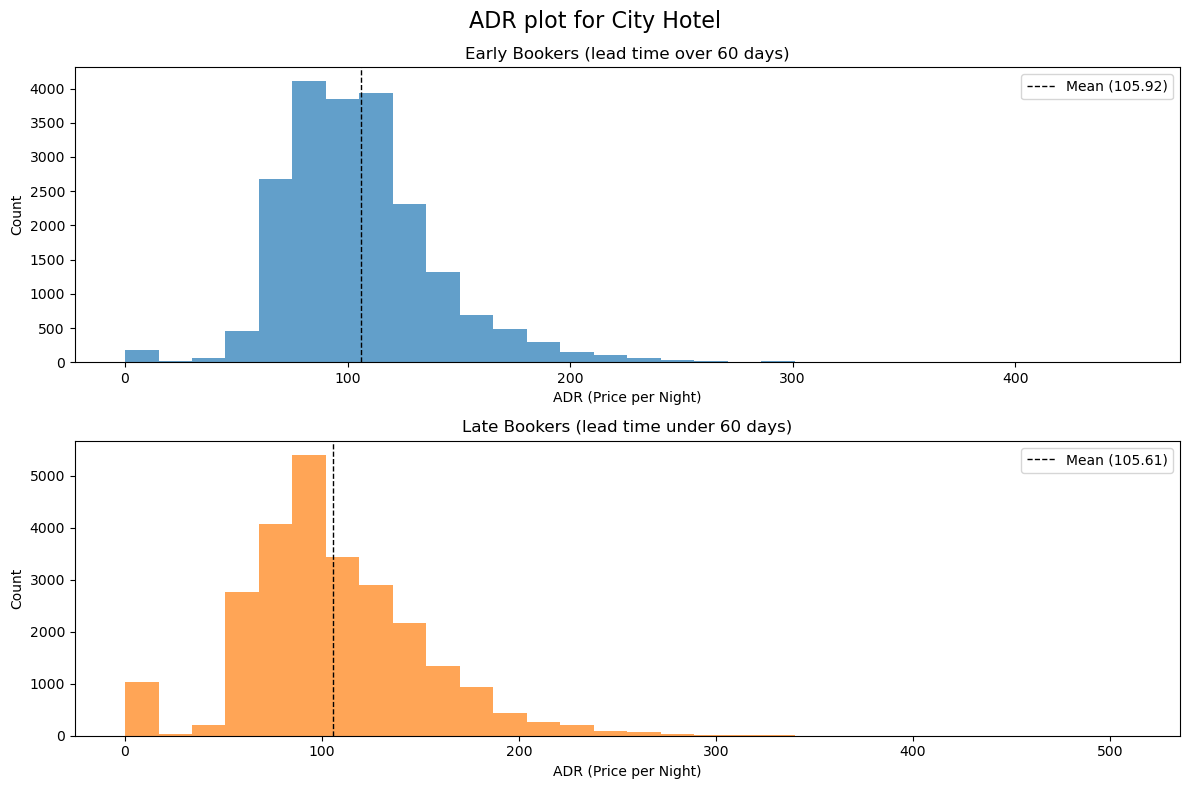

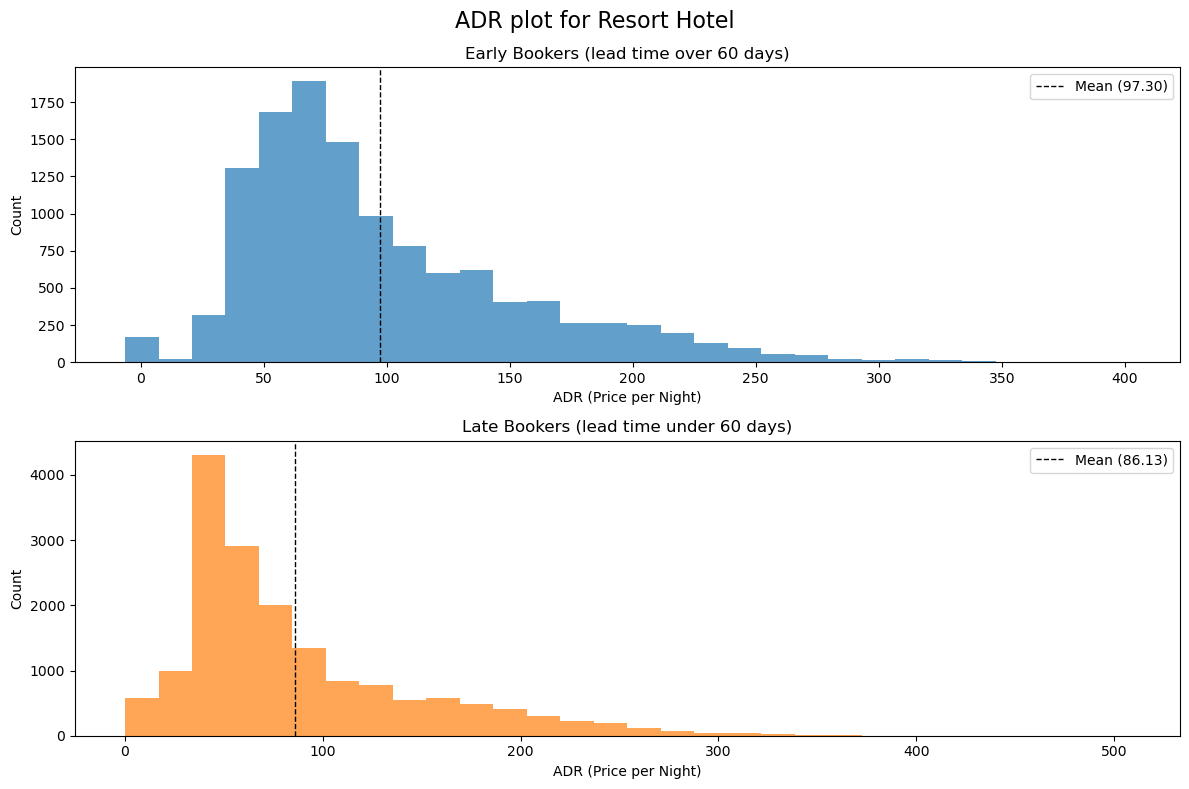

In [311]:
create_adr_plot_by_lead_time_threshhold(
    city_hotel, title="ADR plot for City Hotel", threshhold=60
)
create_adr_plot_by_lead_time_threshhold(
    resort_hotel, title="ADR plot for Resort Hotel", threshhold=60
)

In [312]:
print("Mean ADR that early and late bookers pay (defined by lead_time threshhold)")
print(
    "------------------------------------------------------------------------------------\n"
)

for threshhold in [15, 30, 60, 90]:
    early_city, late_city = get_mean_adr_by_lead_time_threshhold(city_hotel, threshhold)
    early_resort, late_resort = get_mean_adr_by_lead_time_threshhold(
        resort_hotel, threshhold
    )
    print(
        f"City - Threshhold {threshhold} days: ",
        f"Early Bookers: {early_city:.2f}$",
        " - ",
        f"Late Bookers: {late_city:.2f}$",
    )
    print(
        f"Resort - Threshhold {threshhold} days: ",
        f"Early Bookers: {early_resort:.2f}$",
        " - ",
        f"Late Bookers: {late_resort:.2f}$",
    )
    print("----------------------------------")

Mean ADR that early and late bookers pay (defined by lead_time threshhold)
------------------------------------------------------------------------------------

City - Threshhold 15 days:  Early Bookers: 106.38$  -  Late Bookers: 104.17$
Resort - Threshhold 15 days:  Early Bookers: 97.87$  -  Late Bookers: 78.55$
----------------------------------
City - Threshhold 30 days:  Early Bookers: 105.51$  -  Late Bookers: 106.11$
Resort - Threshhold 30 days:  Early Bookers: 98.31$  -  Late Bookers: 82.02$
----------------------------------
City - Threshhold 60 days:  Early Bookers: 105.92$  -  Late Bookers: 105.61$
Resort - Threshhold 60 days:  Early Bookers: 97.30$  -  Late Bookers: 86.13$
----------------------------------
City - Threshhold 90 days:  Early Bookers: 105.93$  -  Late Bookers: 105.65$
Resort - Threshhold 90 days:  Early Bookers: 96.31$  -  Late Bookers: 88.02$
----------------------------------


# Estimating the room number of the hotels


In [313]:
def add_arrival_column(df: DataFrame):
    df["arrival"] = pd.to_datetime(
        df["arrival_date_year"].astype(str)
        + "-"
        + df["arrival_date_month"]
        + "-"
        + df["arrival_date_day_of_month"].astype(str),
        format="%Y-%B-%d",
    )

    return df

In [314]:
def calculate_guests_per_day(hotel: DataFrame):
    # Berechne für jeden Tag die Anzahl der Gäste im Hotel
    df = hotel.copy()
    df = add_arrival_column(df)
    df["nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

    # Erzeuge für jede Buchung alle Aufenthaltstage
    stay_dates = []
    for _, row in df.iterrows():
        for i in range(int(row["nights"])):
            stay_dates.append(row["arrival"] + pd.Timedelta(days=i))
    stay_dates = pd.Series(stay_dates)

    # Zähle Gäste pro Tag
    guests_per_day = stay_dates.value_counts().sort_index()

    return guests_per_day

In [315]:
def show_guests_per_day(hotel: DataFrame):
    plt.figure(figsize=(14, 5))

    # count guests per day at a certain date
    guests_per_day = calculate_guests_per_day(hotel)

    guests_per_day.plot()
    plt.title("Anzahl Gäste pro Tag im Hotel")
    plt.xlabel("Datum")
    plt.ylabel("Anzahl Gäste")
    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()

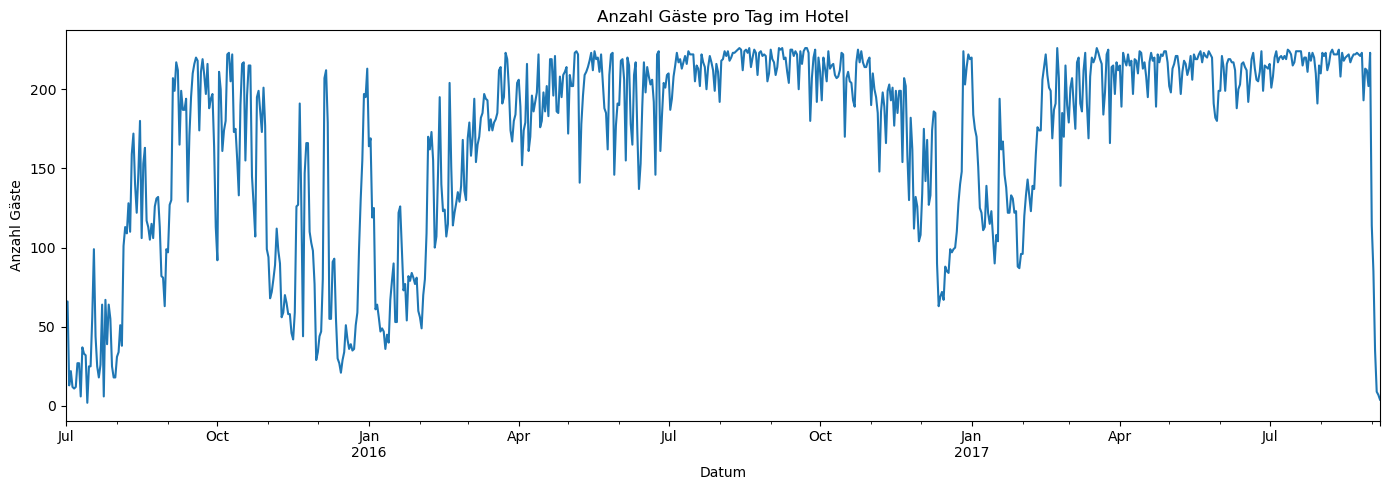

<Figure size 640x480 with 0 Axes>

In [316]:
show_guests_per_day(city_hotel)

In [ ]:
max_guests_city = calculate_guests_per_day(city_hotel).max()
max_guests_resort = calculate_guests_per_day(resort_hotel).max()

print(f"Maximale Gäste an einem Tag im City Hotel: {max_guests_city}")
print(f"Maximale Gäste an einem Tag im Resort Hotel: {max_guests_resort}")

Maximale Gäste an einem Tag im City Hotel: 226
Maximale Gäste an einem Tag im Resort Hotel: 187


## Estimating the high and low demand fare


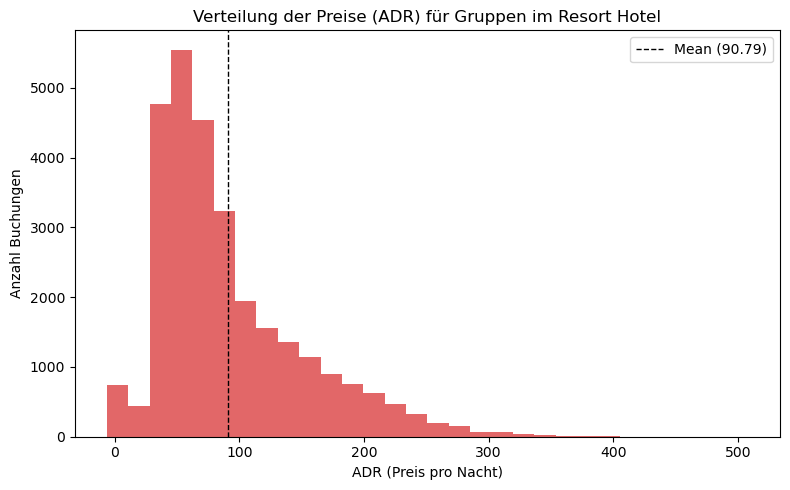

In [318]:
plt.figure(figsize=(8, 5))
plt.hist(resort_hotel["adr"].dropna(), bins=30, color="tab:red", alpha=0.7)
plt.title("Verteilung der Preise (ADR) für Gruppen im Resort Hotel")
plt.xlabel("ADR (Preis pro Nacht)")
plt.ylabel("Anzahl Buchungen")
plt.axvline(
    resort_hotel["adr"].mean(),
    color="black",
    linestyle="dashed",
    linewidth=1,
    label=f'Mean ({resort_hotel["adr"].mean():.2f})',
)
plt.legend()
plt.tight_layout()
plt.show()

In [319]:
low_fare_price_resort = resort_hotel["adr"].quantile(0.1)
high_fare_price_resort = resort_hotel["adr"].quantile(0.9)

low_fare_price_city = city_hotel["adr"].quantile(0.1)
high_fare_price_city = city_hotel["adr"].quantile(0.9)

print(
    f"Low fare price (5% quantile): {low_fare_price_resort:.2f}, {low_fare_price_city}"
)
print(
    f"High fare price (95% quantile): {high_fare_price_resort:.2f}, {high_fare_price_city}"
)

Low fare price (5% quantile): 36.03, 65.0
High fare price (95% quantile): 179.00, 157.5


In [320]:
high_fare_demand_city = (
    len(city_hotel[city_hotel["adr"] > high_fare_price_city]) / len(city_hotel) * 100
)

high_fare_demand_resort = (
    len(resort_hotel[resort_hotel["adr"] > high_fare_price_resort])
    / len(resort_hotel)
    * 100
)


print("City:", high_fare_demand_city)
print("Resort:", high_fare_demand_resort)

City: 9.91390499264515
Resort: 9.941944847605225


# Estimating the distribution of demand D for high fare rooms


In [321]:
from typing import Literal


def calculate_high_fare_demand_distribution(hotel: DataFrame, high_fare_price=150):
    hotel = add_arrival_column(hotel)
    high_fare = hotel[hotel["adr"] > high_fare_price]

    demand_distribution = high_fare.groupby("arrival").size()

    return demand_distribution.value_counts().sort_index()

In [322]:
calculate_high_fare_demand_distribution(city_hotel)

/var/folders/81/lkyc4g5j7_q0sgmn2pdxkcfc0000gn/T/ipykernel_18359/3519912706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["arrival"] = pd.to_datetime(


1     89
2     61
3     51
4     46
5     21
6     21
7     27
8     20
9     25
10    26
11    22
12    14
13    22
14    19
15    19
16    18
17    12
18    15
19    13
20    12
21     8
22     4
23     5
24     8
25     2
26     2
27     2
28     1
29     3
30     5
31     1
32     2
35     1
36     1
37     1
38     1
41     1
47     1
56     1
99     1
Name: count, dtype: int64

In [350]:
def plot_high_fare_demand_distribution(hotel, high_fare_price=150):
    demand_distribution = calculate_high_fare_demand_distribution(
        hotel, high_fare_price
    )
    plt.figure(figsize=(12, 5))
    # Sort the demand_distribution by date (index)
    demand_distribution = demand_distribution.sort_index()
    plt.plot(
        demand_distribution.index,
        demand_distribution.values / sum(demand_distribution.values),
        linestyle="-",
    )
    plt.title(f"High Fare Demand (ADR > {high_fare_price}) per Arrival Date")
    plt.xlabel("Number of High Fare Bookings per Day")
    plt.ylabel("Frequency")
    # Nur den Zeitraum anzeigen, in dem es High-Fare-Buchungen gibt
    if not demand_distribution.empty:
        plt.xlim(demand_distribution.index.min(), demand_distribution.index.max())
    plt.xticks(rotation=45)
    plt.xlabel("Demand D")
    plt.tight_layout()

    # Plot mean as a vertical line
    mean_demand = demand_distribution.values.mean()
    plt.axvline(
        mean_demand,
        color="black",
        linestyle="dashed",
        linewidth=1,
        label=f"Mean ({mean_demand:.2f})",
    )
    plt.legend()

    plt.show()

/var/folders/81/lkyc4g5j7_q0sgmn2pdxkcfc0000gn/T/ipykernel_18359/3519912706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["arrival"] = pd.to_datetime(


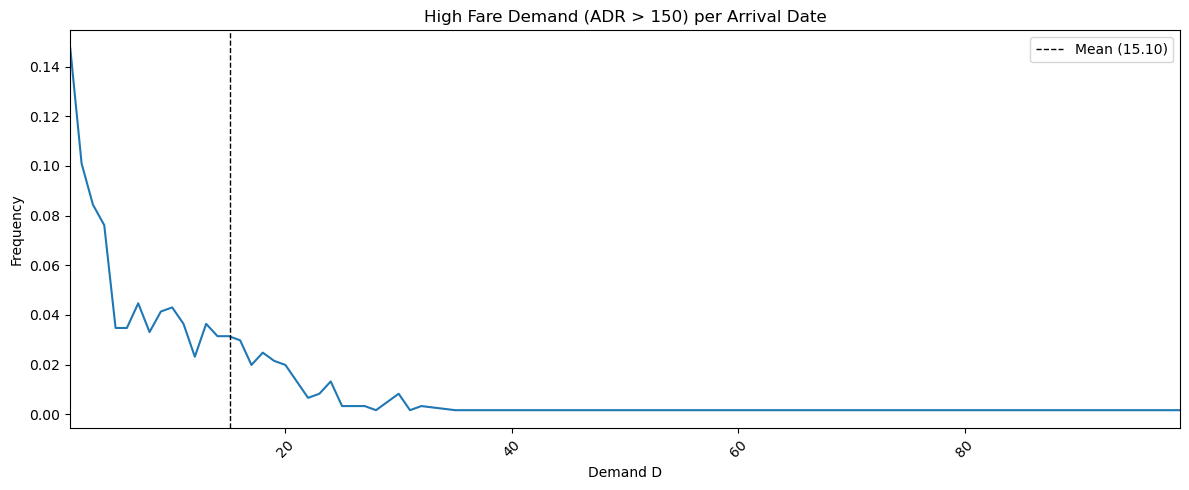

/var/folders/81/lkyc4g5j7_q0sgmn2pdxkcfc0000gn/T/ipykernel_18359/3519912706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["arrival"] = pd.to_datetime(


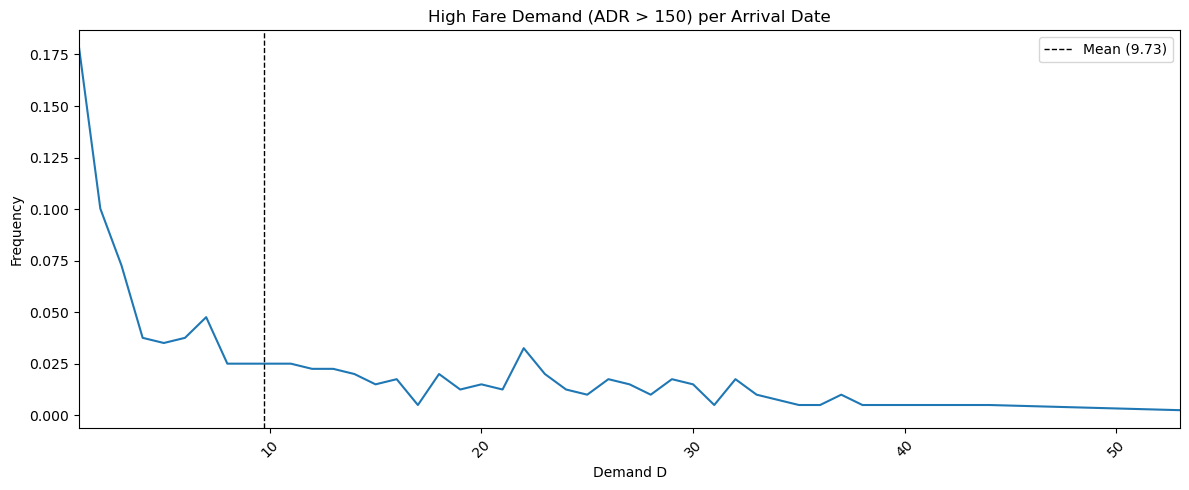

In [351]:
plot_high_fare_demand_distribution(city_hotel, high_fare_price=150)
plot_high_fare_demand_distribution(resort_hotel, high_fare_price=150)

In [353]:
import numpy as np


def plot_with_theoretical_dist(hotel, high_fare_price=150):
    fig, ax = plt.subplots(1, figsize=(18, 5))
    demand_distribution = calculate_high_fare_demand_distribution(
        hotel, high_fare_price
    )

    ax.plot(
        demand_distribution.index,
        demand_distribution.values / sum(demand_distribution.values),
        linestyle="-",
        marker="o",
        label="Empirical Distribution",
    )

    lam = 1 / demand_distribution.values.mean()

    x = np.linspace(0, max(demand_distribution.index.max(), 10), 1000)
    y = lam * np.exp(-lam * x)
    ax.plot(x, y, label=f"Theoretical Exponential ($\\lambda={lam:.4f}$)")

    ax.set_title(f"High Fare Demand (ADR > {high_fare_price}) per Arrival Date")
    ax.set_xlabel("Number of High Fare Bookings per Day")
    ax.set_ylabel("Frequency")
    ax.legend()
    plt.tight_layout()
    plt.show()

/var/folders/81/lkyc4g5j7_q0sgmn2pdxkcfc0000gn/T/ipykernel_18359/3519912706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["arrival"] = pd.to_datetime(


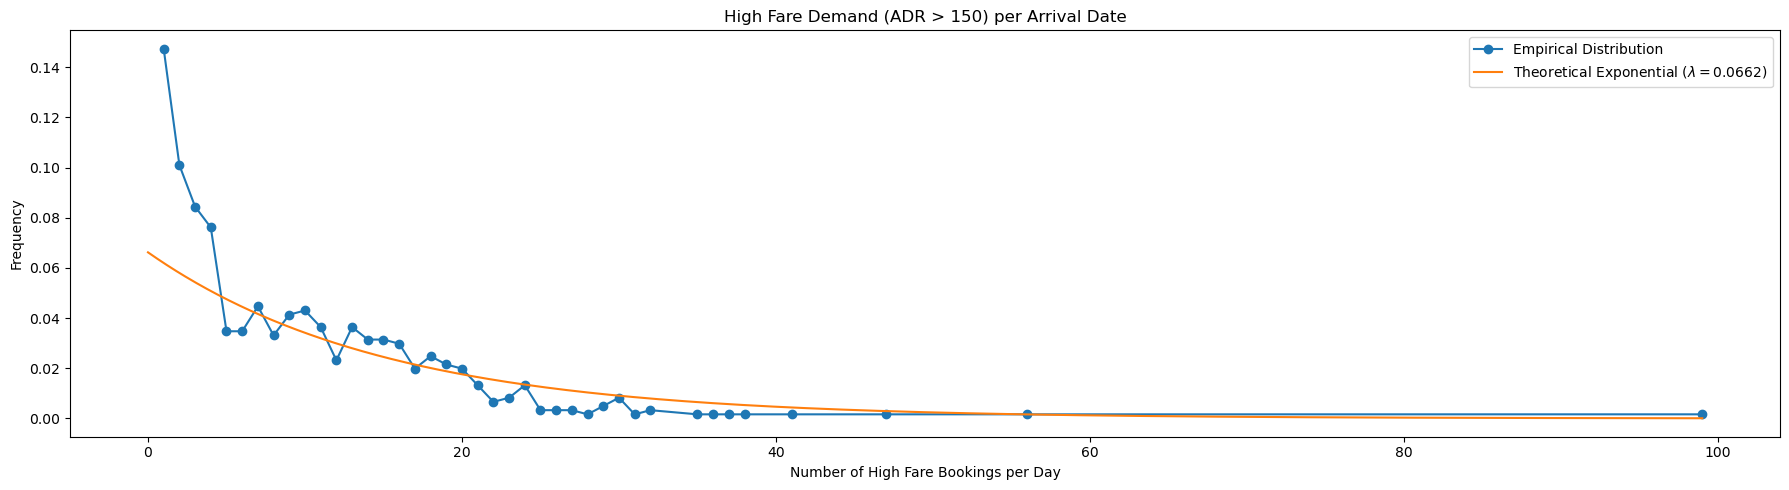

/var/folders/81/lkyc4g5j7_q0sgmn2pdxkcfc0000gn/T/ipykernel_18359/3519912706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["arrival"] = pd.to_datetime(


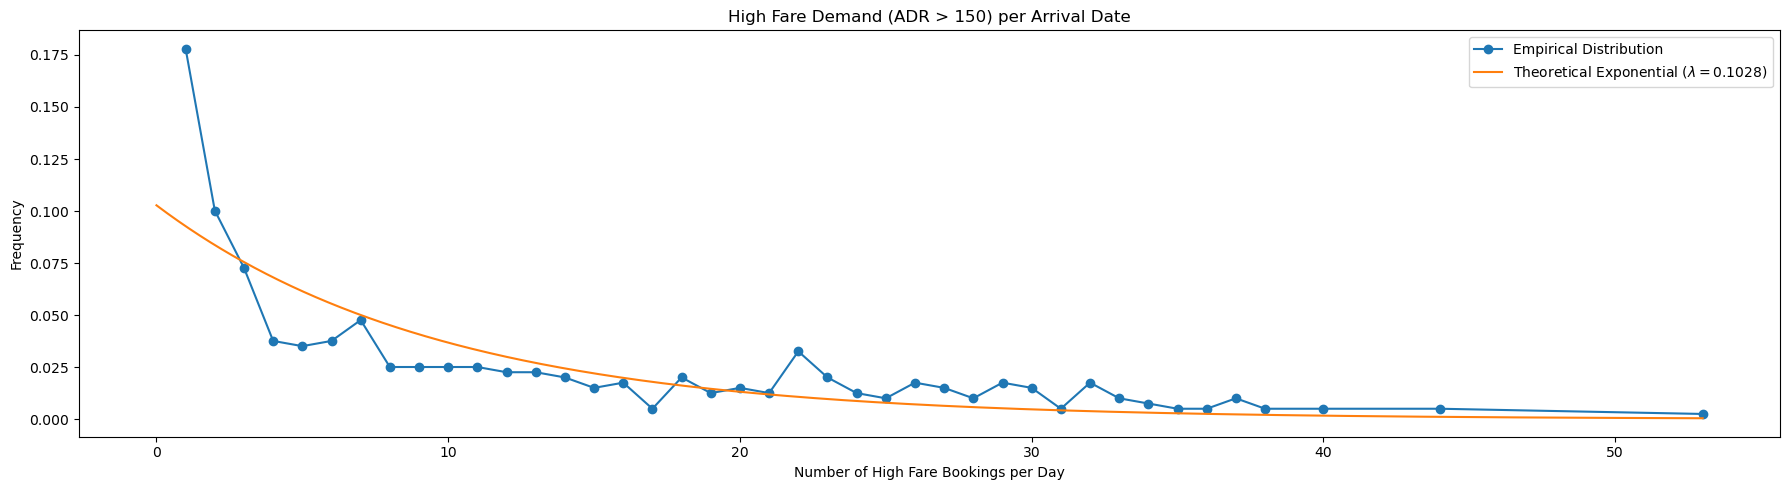

In [354]:
plot_with_theoretical_dist(city_hotel, high_fare_price=150)
plot_with_theoretical_dist(resort_hotel, high_fare_price=150)

# Building the simulation model


In [359]:
total_rooms = 118
low_fare = 159
high_fare = 225
demand_high_fare = 27.3

import numpy as np
from scipy.stats import poisson, expon

import matplotlib.pyplot as plt

In [385]:
estimated_max_occupancy_rate = 0.85
estimated_guests_per_room = 1.75


# Revenue function
def expected_revenue(
    total_rooms,
    low_fare_price,
    high_fare_price,
    mean_demand_high_fare,
    protected_high_fare_rooms,
):
    low_fare_rooms = total_rooms - protected_high_fare_rooms
    revenue = 0
    for d in range(total_rooms + 1):  # Potential high fare demand scenarios
        prob = expon.pdf(d, scale=mean_demand_high_fare)
        if d <= protected_high_fare_rooms:
            # All high fare demand can be accommodated
            revenue += prob * (d * high_fare_price + low_fare_rooms * low_fare_price)
        else:
            # Only protect_high_fare_rooms can be accommodated, rest get low fare
            revenue += prob * (
                protected_high_fare_rooms * high_fare_price
                + low_fare_rooms * low_fare_price
            )
    return revenue


# define variables for city hotel

total_rooms_city = (
    max_guests_city / estimated_max_occupancy_rate / estimated_guests_per_room
)
low_fare_city = get_business_travelers(city_hotel)["adr"].mean()
high_fare_city = get_families(city_hotel)["adr"].mean()
mean_demand_city = calculate_high_fare_demand_distribution(
    city_hotel, high_fare_price_city
)

# define variables for resort hotel

total_rooms_resort = (
    max_guests_resort / estimated_max_occupancy_rate / estimated_guests_per_room
)
low_fare_resort = get_business_travelers(resort_hotel)["adr"].mean()
high_fare_resort = get_families(resort_hotel)["adr"].mean()
mean_demand_resort = calculate_high_fare_demand_distribution(
    resort_hotel, high_fare_price_resort
)


def optimize_revenue(hotel: DataFrame):

    total_rooms = int(
        calculate_guests_per_day(hotel).max()
        / estimated_max_occupancy_rate
        / estimated_guests_per_room
    )
    low_fare_price = get_business_travelers(hotel)["adr"].mean()
    high_fare_price = get_families(hotel)["adr"].mean()
    mean_demand_high_fare = calculate_high_fare_demand_distribution(
        hotel, high_fare_price
    ).mean()

    protected_high_fare_rooms_range = range(total_rooms + 1)
    revenues = [
        expected_revenue(
            total_rooms, low_fare_price, high_fare_price, mean_demand_high_fare, ph
        )
        for ph in protected_high_fare_rooms_range
    ]

    return revenues


revenues = optimize_revenue(resort_hotel)
optimal_protected_high_fare_rooms = np.argmax(revenues)
max_revenue = revenues[optimal_protected_high_fare_rooms]

/var/folders/81/lkyc4g5j7_q0sgmn2pdxkcfc0000gn/T/ipykernel_18359/3519912706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["arrival"] = pd.to_datetime(
/var/folders/81/lkyc4g5j7_q0sgmn2pdxkcfc0000gn/T/ipykernel_18359/3519912706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["arrival"] = pd.to_datetime(
/var/folders/81/lkyc4g5j7_q0sgmn2pdxkcfc0000gn/T/ipykernel_18359/3519912706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [386]:
optimal_protected_high_fare_rooms

10

In [388]:
max_revenue

6941.904361417584

## Q2 – Derive Overbooking Parameters

Clara wants to implement an overbooking policy to mitigate late cancellations and no-shows. But overbooking comes with risk: walk-aways hurt guest satisfaction and brand image.

Use historical data to estimate a robust overbooking buffer for each hotel. How many extra bookings can Clara accept without incurring frequent walk-aways?

Explain any trade-offs and assumptions you make.


## Q3 – Seasonally Update Your Rules

Demand patterns change throughout the year, and Clara would like to **adapt** her advance sale and overbooking thresholds to seasonality.

Using appropriate aggregates from past years, identify periods of stronger or weaker demand for each hotel. How would your advance booking limits and overbooking buffers from Q1 and Q2 change across these periods?

Provide updated rules for both city and resort hotels and justify your logic using observed patterns.


## Q4 – Operate on Live Booking Data

Imagine Clara gives you access to a daily stream of individual bookings coming in for the next season. For each booking, you see the date, stay period, channel, price.

Design a **monitoring system** that updates Clara’s advance sale ceilings and overbooking parameters as real bookings accumulate. What metrics would you track? How would you flag when adjustments are needed?

Use a small mock dataset or simulated example to demonstrate how this dynamic process could work. Highlight how **static rules** (from Q1 and Q2) evolve when applied in real time.


# TODO

- Refactoring Task 1
